# Model Selection 

- 모델링에 활용할 모델 구조를 선택하기 위해 비듬데이터를 대상으로 다양한 모델들을 테스트.
- 본 코드에서는 VGG16, 19를 테스트하기 위해 다음 사항을 시행
1. VGG16 / VGG19
2. TransferLearning
3. Optimization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setting

In [2]:
!pip install ipython-autotime
%load_ext autotime

%cd /content/drive/MyDrive/Final_Project/윤건우

/content/drive/MyDrive/Final_Project/윤건우
time: 4.77 ms (started: 2022-04-14 04:54:51 +00:00)


In [3]:
from glob import glob
import numpy as np
import random as rn
import tensorflow as tf
from keras import backend as K
import os

# path
tp = 'dandruff'
path_train = f'../Train_data/{tp}/'
path_valid = f'../Validation/{tp}/'
path_test = f'../Test/{tp}/'

# seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
rn.seed(seed)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

time: 8 s (started: 2022-04-14 04:55:03 +00:00)


In [4]:
# GPU
%tensorflow_version 2.x

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
time: 11.2 ms (started: 2022-04-14 04:55:11 +00:00)


# Data Setting

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 192 54

train_datagen= ImageDataGenerator(rescale=1./255) # 스케일링만 진행

train_generator = train_datagen.flow_from_directory(path_train,# 데이터가 존재하는 디렉토리
                                                      batch_size=192, # 11개 Batch
                                                      target_size=(224, 224),
                                                      class_mode='categorical', # 다중 분류
                                                    )

valid_datagen= ImageDataGenerator(rescale=1./255)# 스케일링만 진행

valid_generator = valid_datagen.flow_from_directory(path_valid,
                                                  class_mode='categorical',
                                                  target_size=(224, 224),
                                                  batch_size= 52
                                                    )

test_datagen= ImageDataGenerator(rescale=1./255)# 스케일링만 진행

test_generator = test_datagen.flow_from_directory(path_test,
                                                  class_mode='categorical',
                                                  target_size=(224, 224),
                                                    )

Found 12313 images belonging to 4 classes.
Found 8218 images belonging to 4 classes.
Found 4123 images belonging to 4 classes.
time: 2min 40s (started: 2022-04-14 04:55:18 +00:00)


# Transfer Learning - VGG16 ImageNet

In [ ]:
del vgg16
del model

time: 953 µs (started: 2022-04-11 16:55:36 +00:00)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics

# Transfer Learning
# VGG16
with tf.device('/device:GPU:0'):
  vgg16 = VGG16(weights ='imagenet', include_top=False, input_shape=(224,224,3))
  vgg16.trainable = False

  # FN 
  model = Sequential()
  model.add(vgg16)

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(4, activation='softmax'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 4096)              102764544 
                                                                 
 dense_13 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_14 (Dense)            (None, 256)               262400    
                                                                 
 dense_15 (Dense)            (None, 64)                16448     
                                                                 
 dense_16 (Dense)            (None, 16)               

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

savename = 'TF-FN5-trial-002'

filename = './Weight/{}.h5'.format(savename)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=0,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=30,         # Epoch동안 개선되지 않는다면 종료
                             )


# compile
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate=0.0003),
              metrics=['accuracy'])

# train
history = model.fit(train_generator, #steps_per_epoch=30, 
                    epochs=100, validation_data=valid_generator, 
                    validation_steps=4, callbacks=[checkpoint, earlystopping])

Epoch 1/100
  6/226 [..............................] - ETA: 2:15:04 - loss: 1.4780 - accuracy: 0.3932

KeyboardInterrupt: ignored

time: 5min 5s (started: 2022-04-11 16:55:50 +00:00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  y_vloss = history.history['val_loss']
  y_loss=  history.history['loss']

  x_len = np.arange(len(y_loss))
  plt.plot(x_len, acc, marker='.', c='red', label='Trainset_acc')
  plt.plot(x_len, val_acc, marker='.', c='lightcoral', label='Validset_acc')
  plt.plot(x_len, y_vloss, marker='.', c='cornflowerblue', label='Validset_loss')
  plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

  plt.legend(loc='upper right')
  plt.grid()
  plt.xlabel('epoch')
  plt.ylabel('loss/acc')
  plt.show()

plot_(history)

test

In [11]:
 from tensorflow.keras.models import load_model

 model = load_model('./Weight/TF-FN5-trial-002.h5')

time: 17 s (started: 2022-04-14 04:59:28 +00:00)


In [12]:
model.evaluate(test_generator)

129/129 [==============================] - 1243s 10s/step - loss: 0.9265 - accuracy: 0.5867


[0.9265097379684448, 0.5867087244987488]

time: 20min 53s (started: 2022-04-14 05:00:17 +00:00)


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=1)  # Returns maximum indices in each row

class_names = ['Normal','Mild','Moderate','Severe']

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))

print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))

-- Confusion Matrix --
[[   1   43   27    5]
 [  77 1137 1020  131]
 [  42  666  589   63]
 [  13  143  153   13]]
-- Classification Report --
              precision    recall  f1-score   support

      Normal       0.01      0.01      0.01        76
        Mild       0.57      0.48      0.52      2365
    Moderate       0.33      0.43      0.37      1360
      Severe       0.06      0.04      0.05       322

    accuracy                           0.42      4123
   macro avg       0.24      0.24      0.24      4123
weighted avg       0.44      0.42      0.43      4123

time: 14.7 s (started: 2022-04-14 05:21:52 +00:00)


Text(0.5, 1.0, 'dandruff_confusion matrix')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


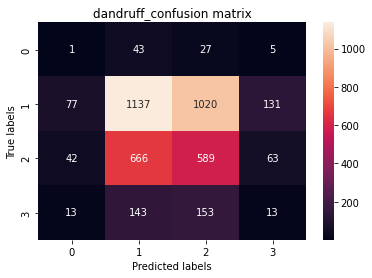

time: 332 ms (started: 2022-04-14 05:28:46 +00:00)


In [16]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

ax = plt.subplot()
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d' )
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title(f'{tp}_confusion matrix')